## CS 583 -- Fall, 2021 -- Final Project


# Chord Recognition - Acoustic Guitars



Our goal for this project is to create a resource for guitarists to be able to learn music theory in a more practical and intuiitive manner.

### Imports From Lecture 18

In [1]:
# General useful imports
import numpy as np
import matplotlib.pyplot as plt
import librosa 
import librosa.display
from IPython.display import Audio

from scipy import signal

from scipy.signal import find_peaks, windows

%matplotlib inline

# Basic audio parameters

SR            = 22050                  #  sample rate default for Librosa

# Utility functions

# Round to 4 decimal places

def round4(x):
    return np.around(x,4)  

# normalize a signal so that its max = 1.0

def normalize(x):
    return x / max(x)

def makeSignal(S=[(440,1,0)], A = None, duration=1.0,sr=SR):
    X = np.zeros(int(sr*duration)) 
    T = np.arange(int(sr*duration))
    for (f,amp,phi) in S:         
        X +=  amp * np.sin( 2 * np.pi * f * T / sr + phi )
    X / max(X)         # normalize to amplitude 1.0
    if(A == None):
        return  X       
    else:
        return  A * X  
    
# get signal array and sample rate from a local audio file, will resample to 
#     default SR of 22050

import soundfile as sf
import io
import warnings

from six.moves.urllib.request import urlopen

def readSignal(name,sr=None):    
    if(name[:5] == 'https'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = sf.read(io.BytesIO(urlopen(name).read()))           
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X, fileSR = librosa.load(name)
    if((sr == None) or (fileSR == sr)):
        return X
    else:
        return librosa.resample(X,fileSR,SR) 

# write signal array out to a file in your local directory (or to complete path name)

def writeSignal(name,data,sr=SR):
    sf.write(name,data,sr)

# Display 


def displaySignal(X, sr=SR, title='Signal Window for X',x_units = "Seconds", figsize=(14,6),gridlines=False): 
    
    if(x_units == "Seconds"):
        T = np.arange(0, len(X)/sr, 1/sr)
    elif(x_units == "Milliseconds"):
        T = np.arange(0, 1000*len(X)/sr, 1000/sr)
    elif(x_units == "Samples"):
        T = np.arange(len(X))

    plt.figure(figsize=figsize)   # Set x and y dimensions of window: may need to redo for your display
    plt.title(title, fontsize=14, fontweight='bold')
    if(x_units=="Samples"):
        plt.xlabel("Sample Number")
    else:
        plt.xlabel(x_units)
    plt.ylabel("Amplitude")
    plt.ylim([-1.1,1.1])
    plt.plot([0,T[-1]],[0,0],color='black')      # draw the 0 line in black
    plt.plot(T,X)                    
    plt.grid(gridlines)                     # if you want dotted grid lines
    plt.show()

import contextlib
import wave
import array

# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = array.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

# Write out an array as a wave file to the local directory
        
def writeWaveFile(fname, X):
    X = [clip(x) for x in X]
    params = [1,2, SR , len(X), "NONE", None]
    data = array.array("h",X)
    with contextlib.closing(wave.open(fname, "w")) as f:
        f.setparams(params)
        f.writeframes(data.tobytes())
    print(fname + " written.")
    
def spectrumFFT(X,filterZeros=True):
    R =  np.fft.rfft(X)
    if(filterZeros):
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) 
                                if not np.isclose(2.0 * np.absolute(R[k])/len(X),0.0) ]) 
    else:
        return np.array([ ( k*SR/len(X), 2.0 * np.absolute(R[k])/len(X),np.angle(R[k])+(np.pi/2) ) 
                            for k in range(len(R)) ]) 
    
def realIFFT(S,A=None):
    S = np.array(S)
    lenX = 2*(len(S)-1)
    complex_S = lenX / 2 * -1.j * S
    X = np.fft.irfft(complex_S)
    if(A == None):
        return X
    else:
        return A * X / max(X)
    
# display the spectrum:   xscale (frequency) can be 'linear' or 'log',
#     and yscale can be 'linear' or 'dB' (essentially log)

def displaySpectrum(X,sr=SR,title='Spectrum of X',xscale='linear',yscale='dB'):
    plt.figure(figsize=(12,6))
    plt.title(title)
    plt.magnitude_spectrum(X,sr,scale=yscale)
    if(xscale == 'linear'):
        plt.xlabel('Frequency (linear)')
    else:    
        plt.xlabel('Frequency (log)')
    if(yscale == 'linear'):
        plt.ylabel('Magnitude (linear)')
    else:    
        plt.ylabel('Magnitude (dB)')
    plt.xscale(xscale)
    plt.show()



##### Onset Detection

In [2]:
    
# Amplitude-based onset detection

def AmplitudeBasedOnsets(X,
                         window_size=512,     # width of the analysis window, in samples
                         hop_length=128,      # how far to move the window each time (could also called "hop_length")
                         scale=10,            # scaling factor for log transformation
                                              # Peak picking parameters:  
                         height=None,           # minimum height (we called this threshold in hw02)          
                         prominence=None,       # relative height compared with nearby peaks; see lecture for details
                         distance=None,         # minimum distance between peaks (to avoid multiple peaks at same onset)
                         displayOnsets=True, # show peaks and onsets
                         displayAll=False):   # To print out displays of various signals
    
    N = len(X)
    
    # Normalize amplitude of X so maximum is 1.0
    
    X = X / max(X)     
    
    # Create the energy envelope by using the sliding window technique to calculate the energy
    # in each window and storing it in a numpy array X_energy. The energy in a window is the mean 
    # of the squared samples. 
    
    # Hints:  Easiest is probably to create empty list and append the energy measurements in 
    # a for loop, then convert to numpy array at end. You should end up with (N // hop_length) - 1
    # values in the array; don't worry about it if the last window is not full size. 
    # Could also do with a list comprehension. 

    num_windows = (N // hop_length) - 1

    window_locations = hop_length * np.arange(num_windows)
    
    # The energy in a window is the mean of the squared samples
    
    def energy(X):
        return (X @ X) / len(X)

    X_energy = np.array( [ energy( X[ w : (w+window_size)] ) for w in window_locations ] )

#    # With a Python list:
#     X_energy = []
#     for w in window_locations:
#         e = energy( X[ w : (w+window_size)] )
#         X_energy.append(e)
    
#     X_energy = np.array(X_energy)
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Signal")
        plt.plot(X_energy)
        plt.show()

    # take the log with scaling factor:   np.log(1.0 + scale * X_energy)
    # if scale = None, do nothing

    if(scale == None):
        X_energy_log = X_energy
    else:
        X_energy_log = np.log(1 + scale*X_energy)

    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Log X Energy Signal with scale factor "+str(scale))
        plt.plot(X_energy_log)
        plt.show()

    # Calculate the novelty function (first difference) using np.diff(...)
    # Watch out:  np.diff(...) changes the array IN PLACE, so make a copy beforehand if you want
    # (debugging is easier if you have all the successive arrays)
    
    # Optional: add 0 at beginning so have exactly the same number of values as X_energy
    
    X_energy_log = np.concatenate([[0],X_energy_log])    

    # Take the discrete differential; watch out, diff transforms array in place

    X_energy_novelty = np.diff(list(X_energy_log)) 
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("X Energy Novelty")
        plt.plot(X_energy_novelty)
        plt.show()
        
    # Now perform half-wave recification by setting all values < 0 to 0. 

    X_energy_novelty_rectified = np.maximum(X_energy_novelty,np.zeros(len(X_energy_novelty)))  
    
    # normalize to 1.0
    
    X_energy_novelty_rectified = X_energy_novelty_rectified / max(X_energy_novelty_rectified)
    
    if(displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Rectified X Energy Novelty")
        plt.plot(X_energy_novelty_rectified)
        plt.show()

    # peak picking using parameters from the argument list: height, prominence, and distance

    peaks,_ = find_peaks(X_energy_novelty_rectified,height=height,prominence=prominence,distance=distance)   
    
    if(displayOnsets or displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Picking Peaks")
        plt.plot(peaks, X_energy_novelty_rectified[peaks], "or")
        plt.plot(X_energy_novelty_rectified)
        plt.show()
    
    # peaks is a list of indices in X_energy_novelty_rectified where peaks were identified; you need to
    # convert from indices in X_energy_novelty_rectified (one value for each sliding window) to sample numbers in X.
    # Important: calculate the location from the MIDDLE of the window.  
    
    onsets = peaks*hop_length + window_size//2

    if(displayOnsets or displayAll):
        plt.figure(figsize=(12,4))
        plt.title("Signal with Onsets")
        plt.plot(X)  
        for k in range(len(onsets)):
            plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
        plt.show()
    
    clicks = librosa.clicks(times=onsets/SR, sr=SR, hop_length=hop_length, length=len(X))
    
    return (onsets,clicks)


##### Distance Function and Other Filters
Auto-Correlation and Filters from Homework 2

Guitar Band-Pass Algorithm Provided by Wayne Snyder

In [3]:
def distance(chroma,template,kind='L2'):      # default is L2 norm
    if(kind == 'L1'):
        return np.sum(np.abs(chroma-template))
    elif(kind == 'L2'):
        return (np.sum((chroma-template)**2))**0.5
    elif(kind == 'CD'):                     # Correlation Distance:  1 + correlation
        s = np.std(chroma)                       # must account for inputs with all 0's
        sn = np.std(template)
        if(np.isclose(s,0) or np.isclose(sn,0)):
            return 0.0
        else:
            return 1.0 - (((chroma - np.mean(chroma)) @ (template - np.mean(template))) / (len(chroma) * s * sn))              
    else:
        return None

import math

def corr(X,Y):
    return (2/len(X))*(X@Y)

def acorrK(X,lag):
    return corr(X[:len(X)-lag],X[lag:])

def acorr(X):
    return [acorrK(X,i) for i in range(math.floor(len(X)/2))]

def applyFilter(W,X):
    Xfull = np.concatenate((np.zeros(len(W)-1),X))
    Xfull = np.concatenate((Xfull,np.zeros(len(W)-1)))
    Y = np.zeros(len(Xfull)-(len(W)-1))
    for i in range(len(W),len(Xfull)+1):
        Y[i-len(W)] = Xfull[i-len(W):i] @ W
    return Y

def makeAvgFilter(K):
    return [1/K for i in range(K)]

kavg = makeAvgFilter(10)

from scipy.signal import butter, sosfilt, sosfreqz

def butter_bandpass(lowcut, highcut, sr = SR, order=5):
        nyq = 0.5 * sr
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, sr=SR, order=5):
        sos = butter_bandpass(lowcut, highcut, sr, order=order)
        y = sosfilt(sos, data)
        return y
    
def guitar_bandpass(x):
    return butter_bandpass_filter(x,70,800)

### Key Identification

In [4]:
key_names = np.array( ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#',
       'G', 'Ab', 'A', 'Bb', 'B'] )

def generate_key_templates(nonkey=False):
    """Generate key templates for major keys (and possibly nonchord)
    """
    template = np.array([1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]).T
    num_key = 12
    if nonkey:
        num_key = 13
    key_templates = np.ones((12, num_key))
    for shift in range(12):
        key_templates[:, shift] = np.roll(template, shift)
    return key_templates

key_templates = generate_key_templates()

print("Key\t Template")
for k in range(len(key_names)):
    print(key_names[k],"\t", key_templates[:,k] )

def apply_key_templates(chroma,dist="L2",key_names=key_names,key_templates=key_templates, display=True):
#     if(display):
#         print("Chord\t Score")
    n = 0
    min_score = 1000000
    scores = []
    for k in range(len(key_names)):
        s = distance(chroma, key_templates[:,k],kind=dist)
        scores.append(s)
#         if(display):
#             print( chord_names[k], "\t", s )
        if(s < min_score):
            n = k
            min_score = s
    
    if(display):
        plt.figure(figsize=(12,6))
        plt.title("Key Distances")
        x = key_names
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, scores)
        plt.xlabel("Key")
        plt.ylabel("Distance from Chroma")
        plt.xticks(x_pos, x)
        plt.show()

        print("\nClosest template: ",key_names[n], "with distance", round4(min_score))
        
    return (key_names[n],min_score)

Key	 Template
C 	 [1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1.]
C# 	 [1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0.]
D 	 [0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.]
Eb 	 [1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.]
E 	 [0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.]
F 	 [1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.]
F# 	 [0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1.]
G 	 [1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1.]
Ab 	 [1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.]
A 	 [0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1.]
Bb 	 [1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0.]
B 	 [0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1.]


Adjustments have been made as needed to the chord identification algorithms in order to identify the key of a given recording. The same general approach is utilized in which the chroma is analyzed, compared to different templates, and then the template that produces the smallest difference is the key that is returned. This approach is derivative of a similar method detailed in a paper by Veronika Zenz and Andreas Rauber.

### Chord Identification 
Also imported from Lecture 18 with some adjustments

In [5]:
# Add 

# returns chroma as a numpy array of length 12

note_names = np.array( ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'] )

def get_chroma(x,sr=SR,window_size=4096):
#     # power spectrum
#     c1 = librosa.feature.chroma_stft(y=x, sr=sr,n_fft=window_size,hop_length=len(x)+1)
#     # magnitude spectrum
#     S = np.abs(librosa.stft(x))
#     c2 = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    # Use a pre-computed power spectrogram 
    S = np.abs(librosa.stft(x, n_fft=window_size))**2
    c = librosa.feature.chroma_stft(S=S, sr=sr,n_fft=window_size,hop_length=len(x)+1)
    return (c.T)[0]

# Below is an attempt at identifying more complex triads (augmented and diminished).
# We found finding major/minor triads to be a difficult enough task so this was scrapped.

# base_chord_names = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']
# tag_chord_names = ['', 'm', 'dim', 'aug']
# chord_names = []
# for tag in tag_chord_names:
#     for chord in base_chord_names:
#         chord_names.append(chord + tag)
# chord_names = np.array(chord_names)

# Make the chord templates for 12 major and 12 minor triads. (from Muller's book)

# def generate_chord_templates(nonchord=False):
#     """Generate chord templates of major and minor triads (and possibly nonchord)
# 
#     Notebook: C5/C5S2_ChordRec_Templates.ipynb
# 
#     Args:
#         nonchord (bool): If "True" then add nonchord template (Default value = False)

#     Returns:
#         chord_templates (np.ndarray): Matrix containing chord_templates as columns
#     """
#     template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
#     template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
#     template_cdim = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]).T
#     template_caug = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0]).T
#     num_chord = 48
#     if nonchord:
#         num_chord = 49
#     chord_templates = np.ones((12, num_chord))
#     for shift in range(12):
#         chord_templates[:, shift] = np.roll(template_cmaj, shift)
#         chord_templates[:, shift+12] = np.roll(template_cmin, shift)
#         chord_templates[:, shift+24] = np.roll(template_cdim, shift)
#         chord_templates[:, shift+36] = np.roll(template_caug, shift)
#     return chord_templates

# chord_templates = generate_chord_templates()

chord_names = np.array( ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#',
       'G', 'Ab', 'A', 'Bb', 'B','Cm', 'C#m', 'Dm', 'Ebm', 'Em', 'Fm', 'F#m',
       'Gm', 'Abm', 'Am', 'Bbm', 'Bm'] )

# Here, we're passing in actual chord chroma to use in chord identification

g = readSignal("G Shape.wav")
gc = np.roll(get_chroma(g),5)
a = readSignal("A Shape.wav")
ac = np.roll(get_chroma(a),3)
am = readSignal("Am Shape.wav")
amc = np.roll(get_chroma(am),3)
c = readSignal("C Shape.wav")
cc = get_chroma(c)
d = readSignal("D Shape.wav")
dc = np.roll(get_chroma(d),-2)
dm = readSignal("Dm Shape.wav")
dmc = np.roll(get_chroma(g),-2)
e = readSignal("E Shape.wav")
ec = np.roll(get_chroma(e),-4)
em = readSignal("Em Shape.wav")
emc = np.roll(get_chroma(em),-4)

# Make the chord templates for 12 major and 12 minor triads. (from Muller's book)

def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates

chord_templates = generate_chord_templates()

# print("Chord\t Template")
# for k in range(len(chord_names)):
#     print(chord_names[k],"\t", chord_templates[:,k] )

# apply distance function to chroma and all possible chords, and print array of 24 distances

def make_chord_indices():
    indices = {}
    for i in range(len(note_names)):
        indices[note_names[i]] = i
    return indices

chord_indices = make_chord_indices()
# print(chord_indices)

def apply_chord_templates(chroma, key, dist="L2",chord_names=chord_names,chord_templates=chord_templates, chord_indices=chord_indices, display=True):
#     if(display):
#         print("Chord\t Score")
    n = 0
    key_steps = [0,5,7,14,16,21]
    min_score = 1000000
    scores = []
    for k in range(len(chord_names)):
        s = distance(chroma, chord_templates[:,k],kind=dist)
        if key != None:
            if ((k - chord_indices[key]) + 24) % 24 in key_steps:
                s /= 2
        scores.append(s)
#         if(display):
#             print( chord_names[k], "\t", s )
        if(s < min_score):
            n = k
            min_score = s
    if(display):
        plt.figure(figsize=(12,6))
        plt.title("Chord Distances")
        x = chord_names
        x_pos = [i for i, _ in enumerate(x)]
        plt.bar(x_pos, scores)
        plt.xlabel("Chord")
        plt.ylabel("Distance from Chroma")
        plt.xticks(x_pos, x)
        plt.show()

        print("\nClosest template: ",chord_names[n], "with distance", round4(min_score))
        
    return (chord_names[n],min_score)

The code above for chord detection has been altered to experiment with a key parameter. By passing in the key of a recording, we can influence our algorithm to favor chords that are more common within the given key (i.e., we would expect to see a G major triad in the key of D major over a G minor triad). Attempts were made to incorporate less common triads like diminished and augmented triads but were unsuccessful. A considered approach was to record chords being played on a guitar and use the chroma observed from these recordings to guide our classification of chords. 8 different open chords were recorded, however we lacked the time to fully implement this approach.

## Testing Key Detection

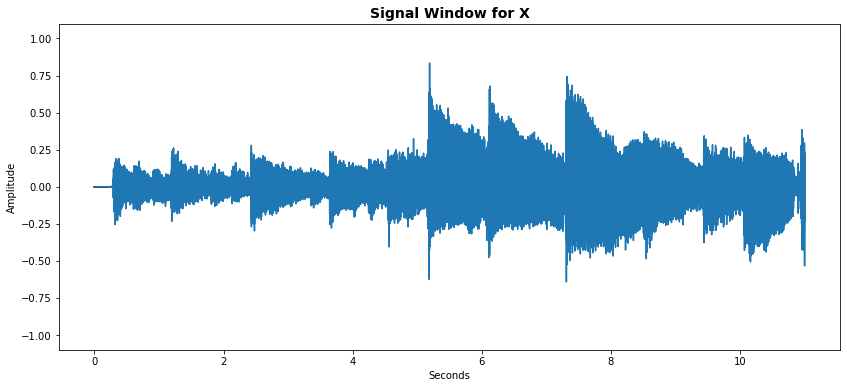

Time - Ben Folds


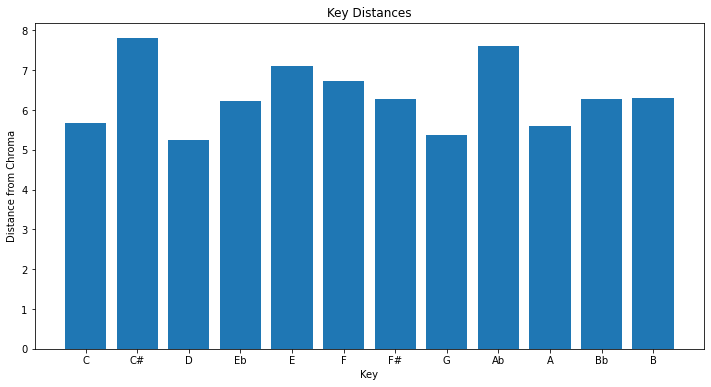


Closest template:  D with distance 5.2494


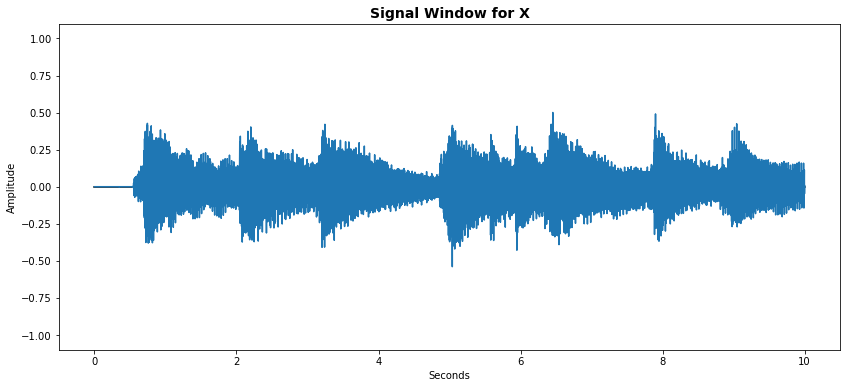

It's the Right Time - Daichi Miura


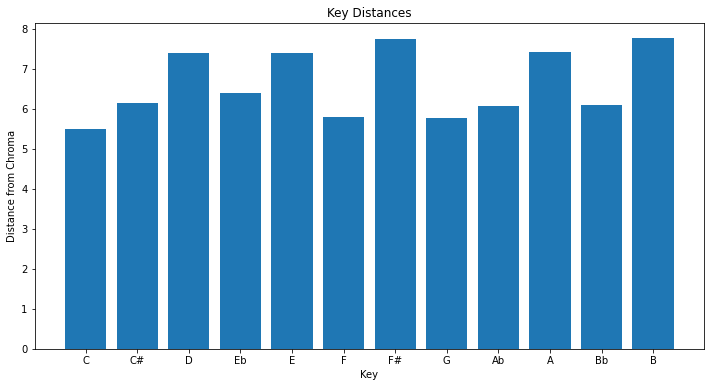


Closest template:  C with distance 5.4851


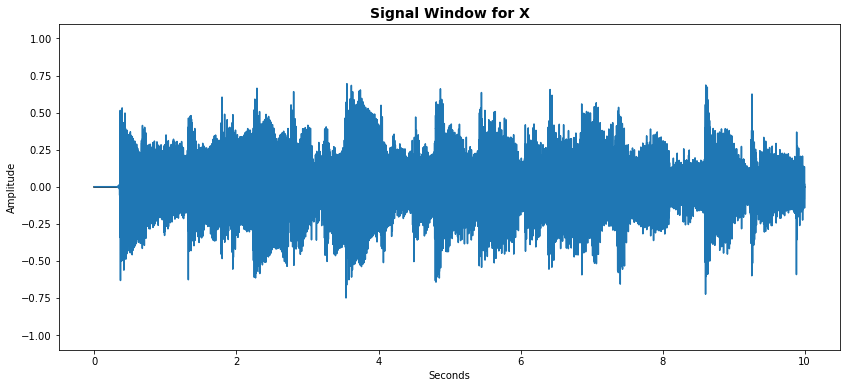

A Thousand Hearts - State Champs


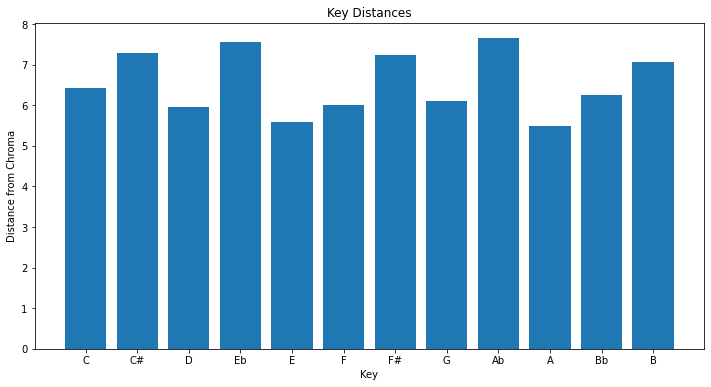


Closest template:  A with distance 5.479


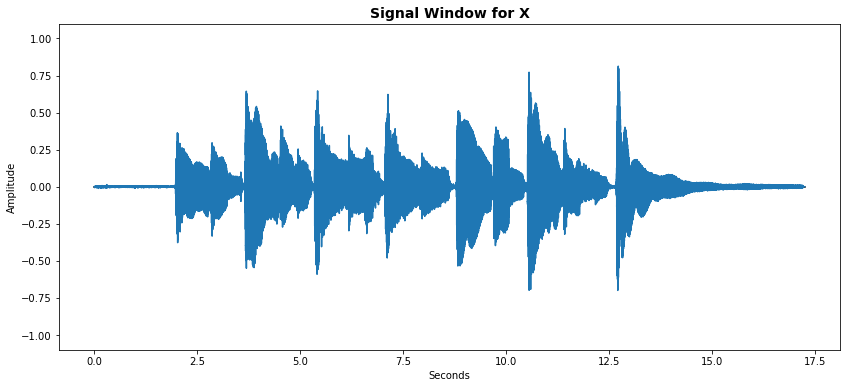

Guitar Playing in the Key of D


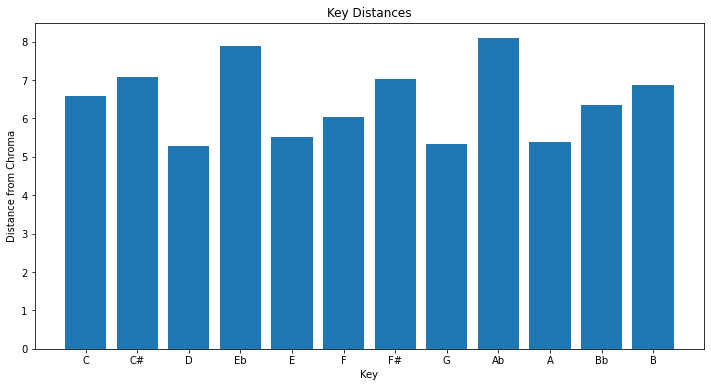


Closest template:  D with distance 5.2846


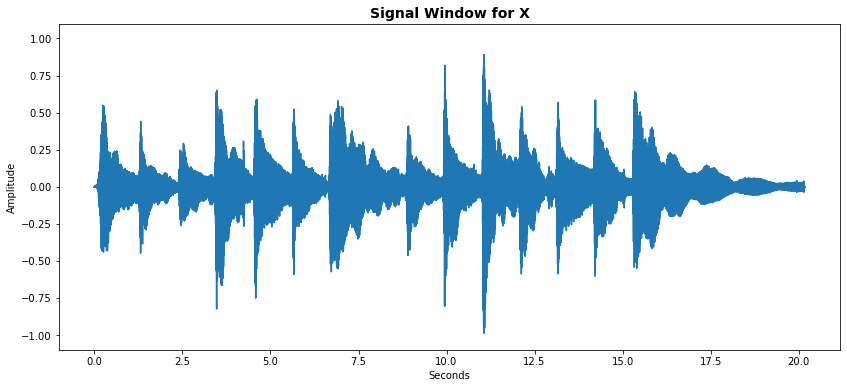

Guitar Playing in the Key of Eb


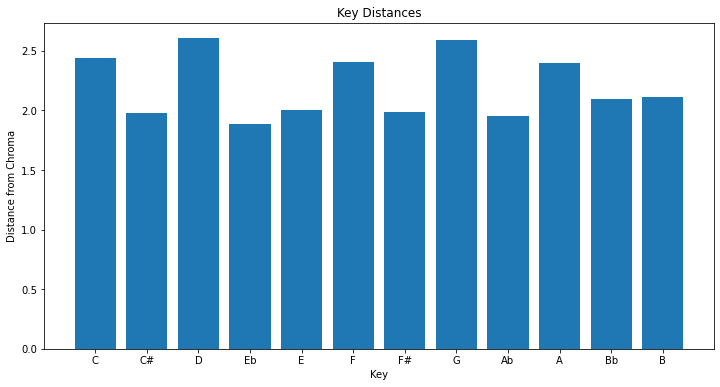


Closest template:  Eb with distance 1.8897


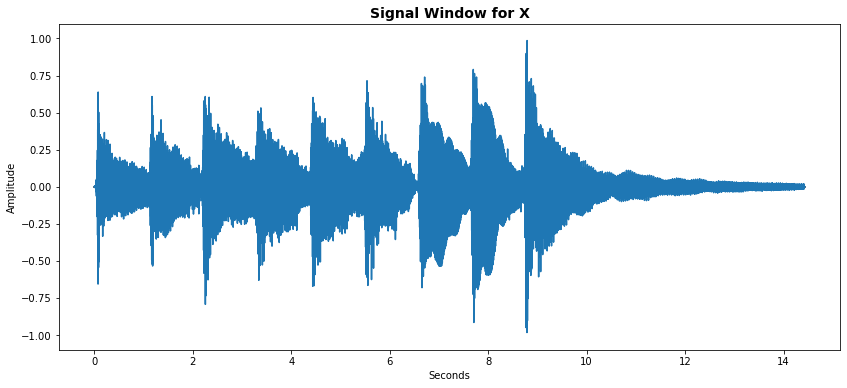

Guitar Playing in the Key of G
[0.05155837 0.17015223 1.         0.21675975 0.19595406 0.04462812
 0.08493492 0.18740219 0.17162951 0.31534747 0.10411681 0.22650247]


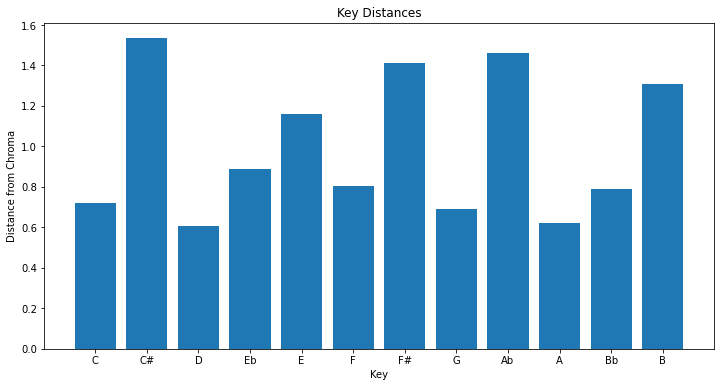


Closest template:  D with distance 0.6083


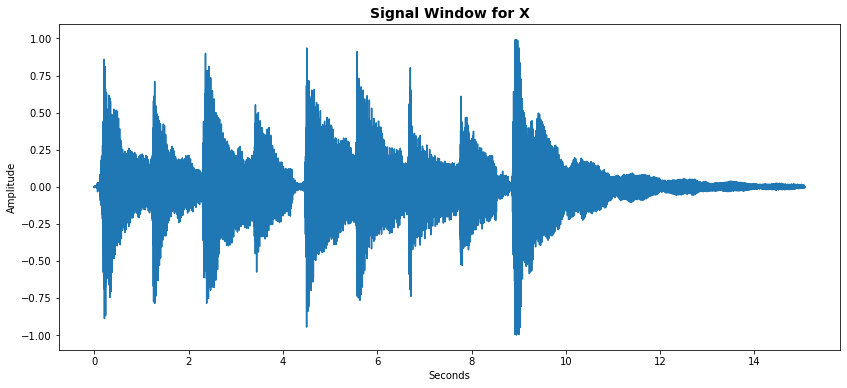

Guitar Playing in the Key of E


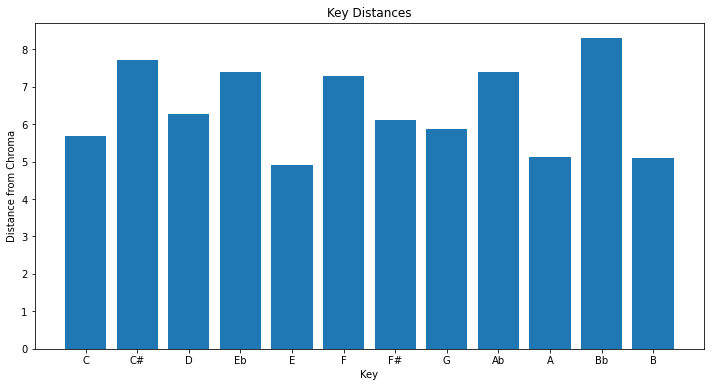


Closest template:  E with distance 4.9135


In [6]:
Y = readSignal("Ben-Folds-Time10.wav")
displaySignal(Y)
Y = applyFilter(kavg,Y)
Audio(Y,rate=SR)
Y = np.array(acorr(Y))
kbf = get_chroma(Y)
print("Time - Ben Folds")
(_,_) = apply_key_templates(kbf,dist="L1")

Y2 = readSignal("Right_Time.wav")
displaySignal(Y2)
Y2 = applyFilter(kavg,Y2)
Audio(Y2,rate=SR)
Y2 = np.array(acorr(Y2))
kr = get_chroma(Y2)
print("It's the Right Time - Daichi Miura")
(_,_) = apply_key_templates(kr,dist="L1")

Y3 = readSignal("Thousand_Hearts.wav")
displaySignal(Y3)
Y3 = applyFilter(kavg,Y3)
Audio(Y3,rate=SR)
Y3 = np.array(acorr(Y3))
ko = get_chroma(Y3)
print("A Thousand Hearts - State Champs")
(_,_) = apply_key_templates(ko,dist="L1")

G1 = readSignal("Guitar D.22050.wav")
displaySignal(G1)
G1 = applyFilter(kavg,G1)
Audio(G1,rate=SR)
G1 = np.array(acorr(G1))
kg1 = get_chroma(G1)
print("Guitar Playing in the Key of D")
(_,_) = apply_key_templates(kg1,dist="L1")

G2 = readSignal("Guitar Eb.wav")
displaySignal(G2)
G2 = applyFilter(kavg,G2)
Audio(G2,rate=SR)
G2 = np.array(acorr(G2))
kg2 = get_chroma(G2)
print("Guitar Playing in the Key of Eb")
(_,_) = apply_key_templates(kg2,dist="L2")

G3 = readSignal("Key of G.wav")
displaySignal(G3)
G3 = applyFilter(kavg,G3)
Audio(G3,rate=SR)
G3 = np.array(acorr(G3))
kg3 = get_chroma(G3)
print("Guitar Playing in the Key of G")
print(kg3)
(_,_) = apply_key_templates(kg3,dist="CD")

G4 = readSignal("Key of E.wav")
displaySignal(G4)
G4 = applyFilter(kavg,G4)
Audio(G4,rate=SR)
G4 = np.array(acorr(G4))
kg4 = get_chroma(G4)
print("Guitar Playing in the Key of E")
(_,_) = apply_key_templates(kg4,dist="L1")

Tests of our key detection algorithm. Our initial attempts were significantly inaccurate. We then tried using auto-correlation to achieve better results and saw a drastic increase in accuracy. As seen in our 3rd guitar recording, our algorithm is not entirely accurate yet. Looking at the chroma for that recording, the note with the highest energy is D. We know that the resonation of the body is a 5th below the fundamental frequency, however the other examples are fairly accurate in terms of detecting the key. We recorded this example playing Gmaj with D on the B string so our hypothesis is that this extra D could be skewing the chroma in that direction or that for whatever reason, the half harmonic is resonating louder for this specific recording only.

### Testing Chord Identification and Key Indentification on Examples

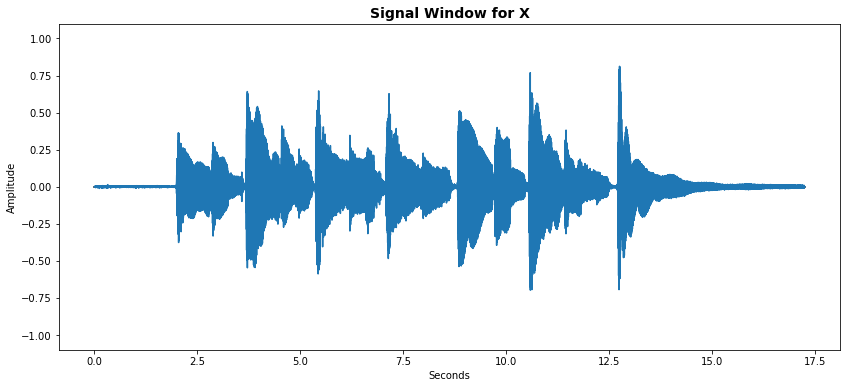

Key


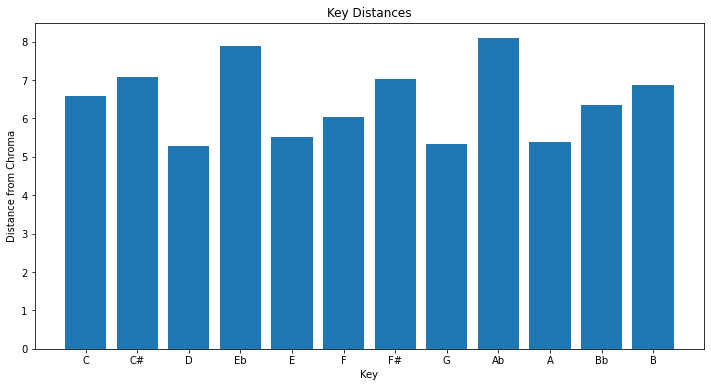


Closest template:  D with distance 5.2846

 Librosa Beat Tracing BPM: 71.77734375


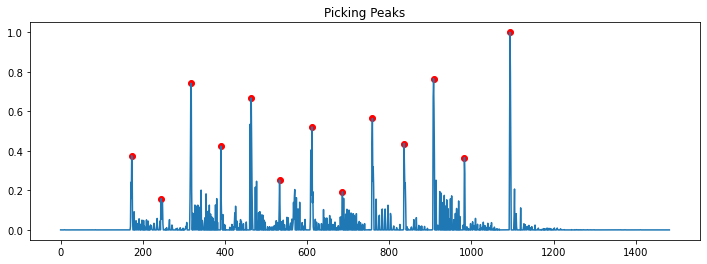

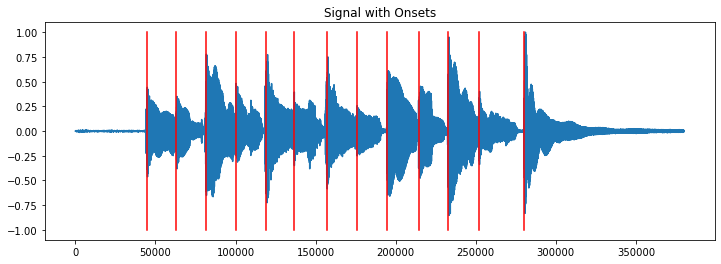

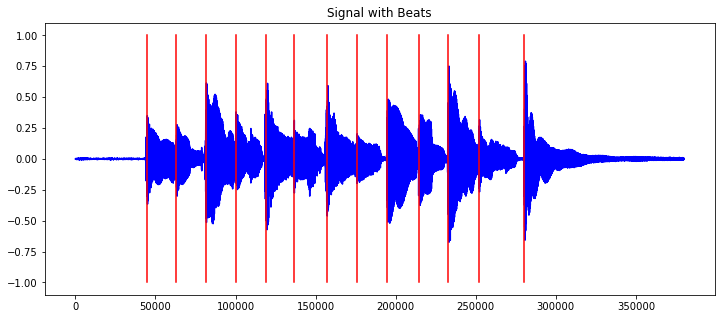

['D', 'D', 'A', 'A', 'G', 'G', 'Em', 'G', 'D', 'D', 'A', 'A', 'G']
Key


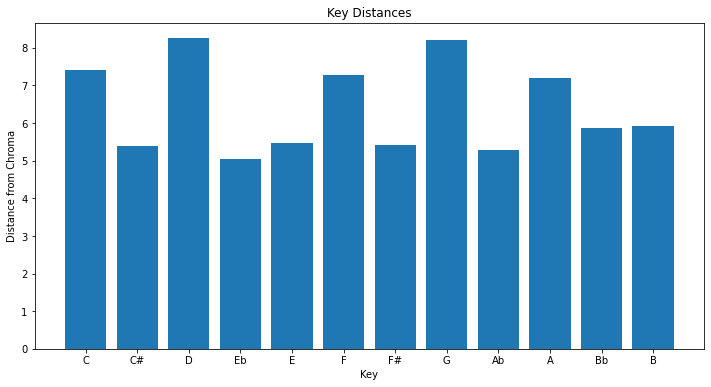


Closest template:  Eb with distance 5.038


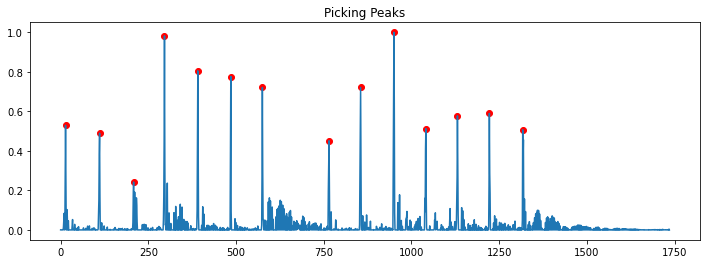

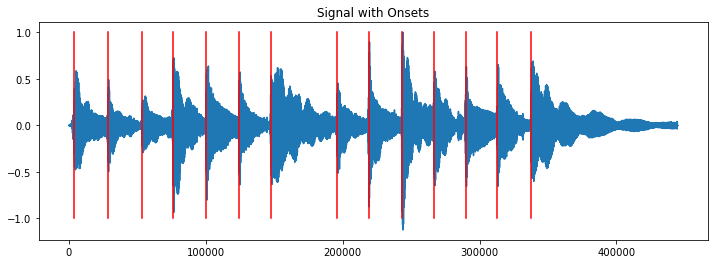

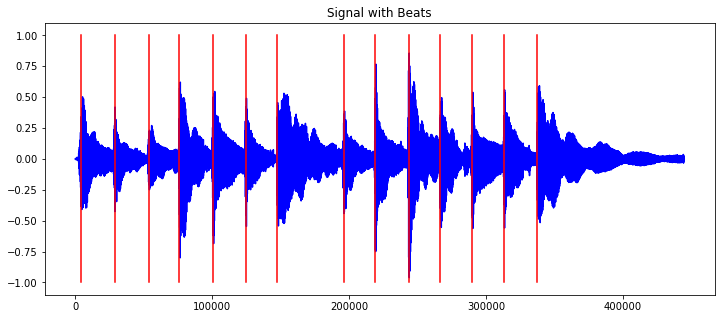

['Ab', 'Eb', 'Eb', 'Ab', 'Ab', 'Ab', 'Bb', 'Ab', 'Eb', 'Ab', 'Ab', 'Eb', 'Ab', 'Bb']
Key


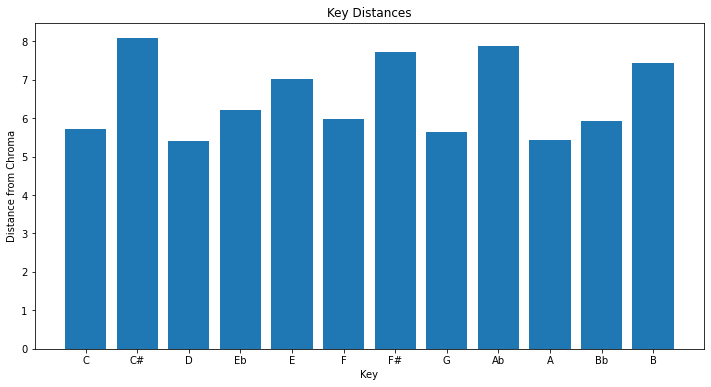


Closest template:  D with distance 5.4111


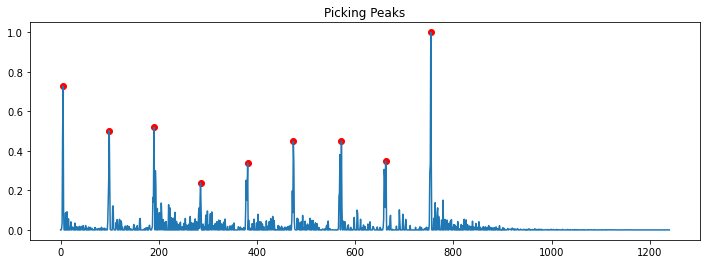

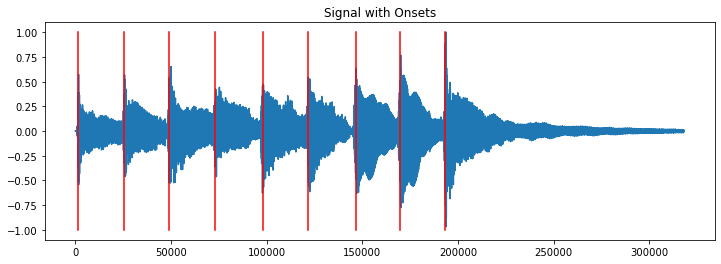

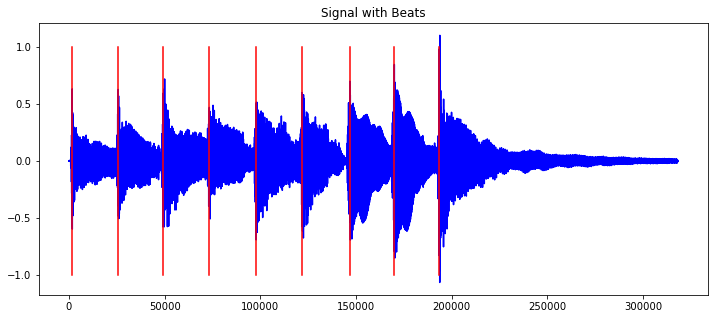

['G', 'Gm', 'Em', 'C', 'Em', 'E', 'D', 'D', 'G']
Key


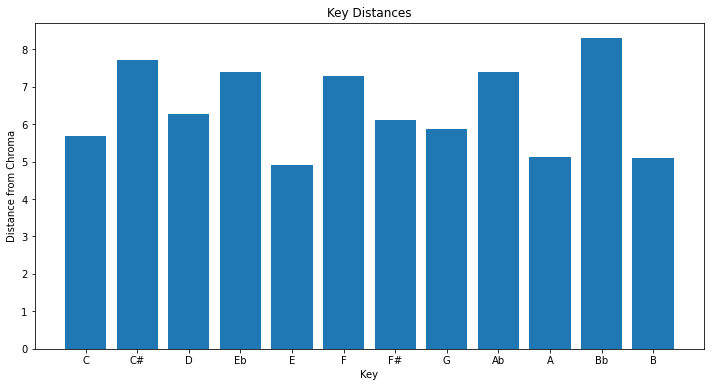


Closest template:  E with distance 4.9135


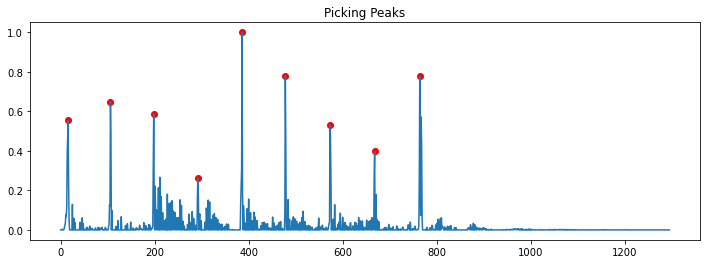

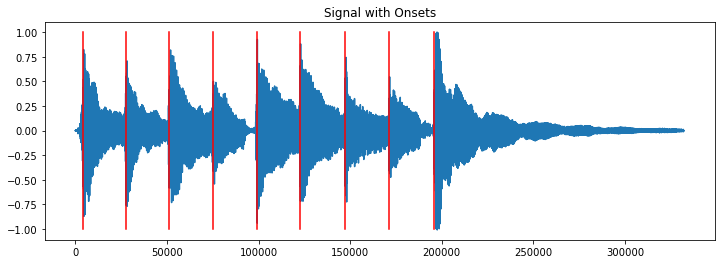

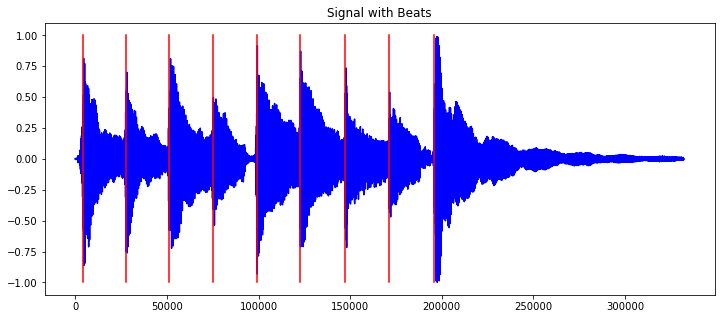

['E', 'E', 'E', 'E', 'E', 'B', 'E', 'E', 'E']


In [7]:
X = readSignal("Guitar D.wav")
displaySignal(X)
Audio(X,rate=SR)

X = applyFilter(kavg,X)
# X = guitar_bandpass(X)
# displaySignal(X)
# X1 = X[44100:80000]

# displaySignal(X1)
# Audio((X1),rate=SR)
# c = get_chroma(X1)
kc = get_chroma(np.array(acorr(X)))

# print("\nNote\tChroma Energy")
# for k in range(12):
#     print(note_names[k],"\t", c[k])
#     print("Keys")
#     print(note_names[k],"\t", kc[k])

# plt.title("Chroma")
# x = note_names
# x_pos = [i for i, _ in enumerate(x)]
# plt.bar(x_pos, c)
# plt.xlabel("Note")
# plt.ylabel("Chroma Energy")
# plt.xticks(x_pos, x)
# plt.show()
# ch = get_chroma(X1)

# print("Chroma", ch,"\n")

# (_,_) = apply_chord_templates(ch,dist="L1")

print("Key")

(xk,_) = apply_key_templates(kc,dist="L1")

tempo, beats = librosa.beat.beat_track(y=X, sr=SR, hop_length=2048)
print("\n Librosa Beat Tracing BPM:",tempo)    

beats = np.array([     0,  18432,  36864,  55296,  73728,  92160, 101376, 110592, 129024,
       147456, 165888, 184320, 202752, 221184, 239616,248832, 258048])

delay = 150

beats += delay

(onsets,clicks) = AmplitudeBasedOnsets(X,
                                         window_size=512,
                                         hop_length=256,
                                         scale=50,
                                         prominence=0.15,
                                         distance=50,
                                         displayAll=False
                                        )
# beats = np.array([ 9216 * k for k in range(30) ])

plt.figure(figsize=(12,5))
plt.title("Signal with Beats")
plt.plot(X,color='b')
for k in range(len(onsets)):
    plt.plot([onsets[k],onsets[k]],[-1,1],color='r')    
plt.show()

# print out chord for each beat

# print('| ',end='')
ch_prog = []
for b in onsets:

    ch = get_chroma(np.array(X[b:(b+18432)]))
    # print("Chroma", ch,"\n")

    (chord_name,dist) = apply_chord_templates(ch,xk,dist="CD",display=False)
    ch_prog += [chord_name]
    
#     print(chord_name+' | ',end='')
print(ch_prog)

X1 = readSignal("Guitar Eb.wav")
X1 = applyFilter(kavg,X1)
kc1 = get_chroma(np.array(acorr(X1)))
print("Key")
(xk1,_) = apply_key_templates(kc1,dist="L1")
(onsets1,clicks1) = AmplitudeBasedOnsets(X1,
                                         window_size=512,
                                         hop_length=256,
                                         scale=50,
                                         prominence=0.2,
                                         distance=50,
                                         displayAll=False
                                        )
plt.figure(figsize=(12,5))
plt.title("Signal with Beats")
plt.plot(X1,color='b')
for k in range(len(onsets1)):
    plt.plot([onsets1[k],onsets1[k]],[-1,1],color='r')    
plt.show()

# print out chord for each beat

# print('| ',end='')
ch_prog1 = []
for b in onsets1:

    ch1 = get_chroma(np.array(X1[b:(b+18432)]))
    # print("Chroma", ch,"\n")

    (chord_name,dist) = apply_chord_templates(ch1,xk1,dist="L1",display=False)
    ch_prog1 += [chord_name]
    
#     print(chord_name+' | ',end='')
print(ch_prog1)

X2 = readSignal("Key of G.wav")
X2 = guitar_bandpass(X2)
X2 = applyFilter(kavg,X2)
kc2 = get_chroma(np.array(acorr(X2)))
print("Key")
(xk2,_) = apply_key_templates(kc2,dist="L1")
(onsets2,clicks2) = AmplitudeBasedOnsets(X2,
                                         window_size=512,
                                         hop_length=256,
                                         scale=50,
                                         prominence=0.2,
                                         distance=50,
                                         displayAll=False
                                        )
plt.figure(figsize=(12,5))
plt.title("Signal with Beats")
plt.plot(X2,color='b')
for k in range(len(onsets2)):
    plt.plot([onsets2[k],onsets2[k]],[-1,1],color='r')    
plt.show()

# print out chord for each beat

# print('| ',end='')
ch_prog2 = []
for b in onsets2:

    ch2 = get_chroma(np.array(X2[b:(b+18432)]))
    # print("Chroma", ch,"\n")

    # Our key isn't accurate for this example yet. We will ignore the key for now.
    (chord_name,dist) = apply_chord_templates(ch2,None,dist="L1",display=False)
    ch_prog2 += [chord_name]
    
#     print(chord_name+' | ',end='')
print(ch_prog2)

X3 = readSignal("Key of E.wav")
X3 = applyFilter(kavg,X3)
kc3 = get_chroma(np.array(acorr(X3)))
print("Key")
(xk3,_) = apply_key_templates(kc3,dist="L1")
(onsets3,clicks3) = AmplitudeBasedOnsets(X3,
                                         window_size=512,
                                         hop_length=256,
                                         scale=50,
                                         prominence=0.2,
                                         distance=50,
                                         displayAll=False
                                        )
plt.figure(figsize=(12,5))
plt.title("Signal with Beats")
plt.plot(X3,color='b')
for k in range(len(onsets3)):
    plt.plot([onsets3[k],onsets3[k]],[-1,1],color='r')    
plt.show()

# print out chord for each beat

# print('| ',end='')
ch_prog3 = []
for b in onsets3:

    ch3 = get_chroma(np.array(X3[b:(b+18432)]))
    # print("Chroma", ch,"\n")

    (chord_name,dist) = apply_chord_templates(ch3,xk3,dist="L1",display=False)
    ch_prog3 += [chord_name]
    
#     print(chord_name+' | ',end='')
print(ch_prog3)

Tests on all 4 of our recorded files. When compared to before we had implemented weighted differences based on a detected key, accuracy is much better (not used on the 3rd example as the wrong key was being returned). While not perfect, our first example shows a lot of promise. Besides some inversions of chords, this detection is completely accurate. In our second example, accuracy goes down but is still semi-consistent with the actual recording. Interestingly enough, our 3rd example (in the key of G) is the only one where using the bandpass filter improved accuracy. This leads us to assume that for whatever reason, body resonation is much more apparent in our 3rd example. This causes our algorithm to detect most G chords as D because we have that strong half harmonic energy as seen in the chroma from before. As for our last example, the actual chords being played are \[E, E, Asus2, Asus2, C#m7, C#m7, Bsus4, Bsus4, E\]. We used this example knowing that it wouldn't be fully accurate but we wanted to observe what would happen in this case. We found that the constant presence of the open B and E strings presumably skew most of the chords to be detected as Emaj.

## Conclusion:
Our project idea was to implement a chord recognition algorithm for acoustic guitars. Our inspiration for the project originated from the idea that an easy to use chord detection tool could help guitar players better comprehend the underlying music theory of chords and what makes up a chord.

As a starting point, we were given the code to detect a chord’s chroma. In order to improve the accuracy of the chord recognition algorithm, we decided to include “context” to the chords detected. Our initial approach to solving this problem was to detect the key of the guitar chord progression, then if a chord’s similarity to several chords were negligible, we would choose the chord that is used most frequently in the given key.

However, we realized that music theory and chord analysis can be a very challenging field to understand. While our logic was consistent with much of the research we came across, we ran into several problems with the original signals. Particularly, that the chroma of our recordings were off by a significant margin. As such, our algorithm returned incorrect chords so we decided to preprocess the signals with a variety of approaches including: autocorrelation, moving average filters, and band-pass filters. Some worked with varying degrees of success, but we ended up using the moving average filter approach. We used autocorrelation for the sole prupose of idenitifying key signatures.

With the limited amount of time we had to work on the project, we definitely had issues we could not address and features we couldn’t implement within the scope and timeline of our project. However, during our ideation period, we came up with lots of potential ideas to enhance our chord recognition algorithm. Our researched materials outlined several preprocessing methods to help improve accuracy, however we were unable to implement these due to time constraints (specifically, the pitch detection outlined by Larry Wu). With more time and experimentation, we believe that implementing more of these ideas could lead to a much better result. We also wanted to find a way to differentiate between major and minor keys. We theorized that an approach to this problem could also help us differentiate inversions of the same chord but were unable to come up with a solution within the time period of this project. Additionally, we wanted to implement recognition for more complex chords such as diminished/augmented triads and seventh chords (as well as other added notes). We also could expand to recognize chord shapes using UI elements to make visualizing and practicing these chords much easier. Finally, in a long view, we envisioned a mobile application that functioned as a learning aid for the guitar.


### Bibliography:
Guitar Sound Analysis and Pitch Detection - Larry Wu

    https://ccrma.stanford.edu/~larrywu/files/GuitarPitchDetection.pdf

CHORD DETECTION USING DEEP LEARNING - Xinquan Zhou and Alexander Lerch

    https://musicinformatics.gatech.edu/wp-content_nondefault/uploads/2015/10/Zhou_Lerch_2015_Chord-Detection-Using-Deep-Learning.pdf

Automatic Chord Detection Incorporating Beat and Key Detection - Veronika Zenz and Andreas Rauber

    https://ieeexplore.ieee.org/abstract/document/4728534

MINIMUM CLASSIFICATION ERROR TRAINING TO IMPROVE ISOLATED CHORD RECOGNITION - J.T. Reed et al.

    https://archives.ismir.net/ismir2009/paper/000119.pdf

Exploring Algorithmic Musical Key Recognition - Nathan J. Levine

    https://scholarship.claremont.edu/cgi/viewcontent.cgi?article=2224&context=cmc_theses

